In [1]:
## TODO: poisson rv for next states for balancing values? 
# you can use expected values of the dist, not sampling from it. 

# write test cases for poisson 
# keep things in the loop, pretty flat. 

A second version of Jack's car rental problem.

## Setup 

#### Packages

In [145]:
import numpy as np
from scipy.stats import poisson
from itertools import product
import matplotlib.pyplot as plt 
%matplotlib inline
from IPython.core.debugger import set_trace

### Functions

#### Reward and state functions

In [3]:
def get_moving_car_cost(cars_moved, car_move_cost=-2): 
    return cars_moved * car_move_cost

In [4]:
def get_rental_money(cars, rentals=[3,4], rent_income=10): 
    """Return the amount of rental money expected for the next day. 
    cars: list of length 2, the number of cars at each location"""
    cars_rented = [min(cr, rntl) for cr, rntl in zip(cars, rentals)]
    return sum(cars_rented) * 10

In [5]:
def get_cars_left(cars, rentals = [3,4], returns = [3,2], max_cars = 20): 
    return ([min(max(cr-rntl,0) + rtn, max_cars) 
             for cr,rntl,rtn in zip(cars, rentals, returns)])

#### Poisson pdf functions

In [6]:
def get_poisson_pdfs(mu_list): 
    """Returns poisson pdf f(x) given vector of distributionmeans `mu_list`.
    , for all values with f(x) > 0.0025"""
    return([[poisson(mu).pmf(x) for x in range(100) if poisson(mu).pmf(x) > 0.0025] 
             for mu in mu_list])

In [7]:
def get_compressed_pdfs(pdfs, max_x =20):
    """
    Truncates pdf f(x) at an upper point, adding together all values higher than the 
    given point. e.g. if we have max 20 cars in a carpark, the probability
    of having 20 cars in the carpark will equal P(20) + p(21) + p(22).... 
    In other words, compresses pdfs to domain [0, max_x]. 
    Parameters:
        pdfs: list of lists, containing pdf f(x) 
        max_x: Add together all f(x) values higher than x
    Output: list of lists with compressed pdf
    """
    compress_pdfs = list()
    for pdf in pdfs: 
        n = len(pdf)
        if n <= max_x: #don't compress, return extra zeros 
            compress_pdfs.append([pdf[i] if i < n else 0 for i in range(max_x+1)])
        else:  # roll up last n - max_x entries 
            compress_pdfs.append([pdf[i] if i < (max_x) else round(sum(pdf[max_x:]),3)
                          for i in range(max_x+1)])
    return compress_pdfs 

#### Function to generate s' and p(s' | s, a)

In [8]:
def get_sprime_and_p_sprime(rental_mu, return_mu, max_cars): 
    # Generate poisson pdf's for the range x = 0 to max_cars 
    rental_pdfs = get_poisson_pdfs(rental_mu)
    return_pdfs = get_poisson_pdfs(return_mu)
    # Compress the domain of the pdf to [0, max_cars]
    sprime_rental = get_compressed_pdfs(rental_pdfs, max_x = max_cars)
    sprime_return = get_compressed_pdfs(return_pdfs, max_x = max_cars)
    # Find all possible s' options
    car_range = [i for i in range(max_cars+1)]
    sprime_list = list(product(car_range, repeat=4))
    # Calculate the probability of each potential new state s'
    p_sprime = [rntl1*rntl2*rtn1*rtn2 for rntl1, rntl2, rtn1, rtn2
     in product(sprime_rental[0],sprime_rental[1],sprime_return[0],sprime_return[1])]
    return (sprime_list, p_sprime)

#### Function for policy evaluation

Here is the Bellman equation for the state-value function $q_\pi(s,a)$
$$ q_\pi(s,a) = \sum_{s'} p(s'| s,a) \left[ r(s,a,s') + \gamma \sum_{a'} \pi(a' | s') q_\pi(s', a')   \right] $$

In [209]:
def policy_evaluation(k, q, policy, actions):
    """Given a `policy` and a action-value function `q`, run policy evaluation `k` times."""
    (sprime_list, p_sprime) = get_sprime_and_p_sprime(rental_mu, return_mu, max_cars)
    p_sprime_mask = [o > 0 for o in p_sprime]
    sprime_list = [o for i,o in enumerate(sprime_list) if p_sprime_mask[i] == True]
    p_sprime = [o for i,o in enumerate(p_sprime) if p_sprime_mask[i] == True]
    for iteration in range(k): 
        print(iteration)
        for c1, c2 in product(range(max_cars+1), repeat=2):
            for i,a in enumerate(actions):
                bellman_bracket = [0 for o in range(len(sprime_list))]
                for j, (rntl1, rntl2, rtn1, rtn2) in enumerate(sprime_list):
                    # find s', p(s')
                    cars = [min(max(0,c1 + a[0]), max_cars), min(max(0, c2 + a[1]), max_cars)]
                    sprime = get_cars_left(cars, [rntl1,rntl2], [rtn1,rtn2], max_cars)
                    # find r(s,a,s')
                    rwd = 0 
                    rwd += get_moving_car_cost(max(a),car_move_cost)
                    rwd += get_rental_money(cars, [rntl1,rntl2], rent_income)
                    # find the brackets term in Bellman eqn
                    bellman_bracket[j] = rwd + gamma * \
                        np.dot(policy[sprime[0]][sprime[1]], q[sprime[0]][sprime[1]])
                # update q with the whole bellman eqn
                print(a)
                print(bellman_bracket)
                print([str(round(o,3)) for o in p_sprime])
                q[c1][c2][i] = np.dot(p_sprime, bellman_bracket)
    return q 

#### Function for policy improvement 

In [210]:
def policy_improvement(policy, q): 
    set_trace()
    best_actions = np.argmax(q, axis=2)
    policy_flat = np.array([[1 if i == o else 0 for i in range(len(actions))] 
              for o in list(best_actions.flat)])
    # Reshape to (max_cars,max_cars, number_of_actions)
    policy = policy_flat.reshape(len(policy[0]),len(policy[0]),len(policy[0][0])).tolist()
    return policy

## Policy evaluation

#### Parameters and initialisation of policy and action-value functions

In [211]:
gamma = 0.9
max_cars = 2 # max cars at a location 
max_cars_moved = 1
car_move_cost = -2 
rent_income = 10 

# Poisson variables - mean mu
rental_mu = [3,4]
return_mu = [3,2]

In [212]:
actions = [(i, -i) for i in range(-max_cars_moved, max_cars_moved+1)] 
q = [[[0 for a in range(len(actions))] 
      for c2 in range(max_cars+1)] for c1 in range(max_cars+1)]
# We start with the equiprobable random policy
policy = [[[1/len(actions) for a in range(len(actions))] 
      for c2 in range(max_cars+1)] for c1 in range(max_cars+1)]

## Policy iteration

In [213]:
# set k=1 for value iteration
for i in range(1):
    k = 1
    q = policy_evaluation(k, q, policy, actions)
    #policy = policy_improvement(policy, q)

0
(-1, 1)
[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]
['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.001', '0.002', '0.0', '0.001', '0.001', '0.001', '0.002', '0.004', '0.005', '0.01', '0.021', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.001', '0.001', '0.0', '0.0', '0.0', '0.0', '0.0', '0.001', '0.001', '0.002', '0.005', '0.001', '0.002', '0.004', '0.003', '0.005', '0.012', '0.015', '0.029', '0.064', '0.0', '0.0', '0.0', '0.0', '0.001', '0.001', '0.002', '0.003', '0.007', '0.0', '0.001', '0.002', '0.001', '0.002', '0.005', '0.0

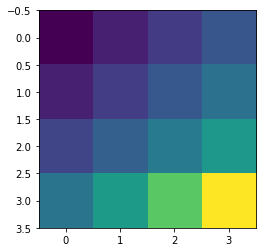

In [182]:
# Value of each state 
v = np.mean(q, axis=2)
plt.imshow(v)

In [184]:
q

[[[14.811032448097434,
   7.7883198024549039,
   0.027307651844380866,
   7.4839780388800667,
   13.459021867101846],
  [22.418788181081265,
   16.898379731192332,
   9.9049181879899812,
   7.6210499671963063,
   13.582035494315392],
  [22.560846435790353,
   24.600706553138508,
   19.109272145496892,
   17.578602799667394,
   13.770566227051148],
  [22.783761788425586,
   24.856317823802286,
   26.936534467424746,
   26.888646965697081,
   23.791456139892574]],
 [[15.646880306065665,
   8.6483269487996175,
   10.30955172093147,
   16.180581999590487,
   19.752892869258297],
  [23.44137894564464,
   18.028025229571675,
   20.517044786780353,
   16.673595443562913,
   20.170898052267468],
  [24.039449957136505,
   26.192474682298894,
   30.25616557405279,
   27.149028996496789,
   20.774314938782432],
  [24.919132865488784,
   27.183794524982687,
   38.801912907090816,
   37.161717678259201,
   31.356299271304085]],
 [[18.980968947811135,
   21.2766171056453,
   21.049930448672136,
   2

In [183]:
policyq

[[[0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2]],
 [[0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2]],
 [[0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2]],
 [[0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2],
  [0.2, 0.2, 0.2, 0.2, 0.2]]]

In [168]:
# The number of cars to transfer at each state 
# From first to second location?
cars_moved = [[actions[np.argmax(y)][0] for y in x] for x in policy]

In [170]:
cars_moved

[[-3, -3, -3, -3, -3, -2, -1, 2],
 [3, -3, -3, -3, -3, 0, 1, 1],
 [3, 3, 0, 0, 0, 0, 0, 1],
 [3, 3, 0, 0, 0, 0, 0, 0],
 [3, -1, -1, 0, 0, 0, 0, 0],
 [-2, -2, -1, -1, -1, 0, 0, 0],
 [-3, -2, -2, -2, -1, -1, 0, 0],
 [-3, -3, -3, -2, -2, -1, 0, 0]]

TypeError: Length of x must be number of columns in z.

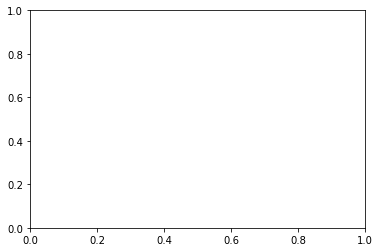

In [169]:
X = [i for i in range(max_cars)]
Y = [i for i in range(max_cars)]
plt.contour(X,Y,cars_moved)

In [ ]:
cars_moved

In [131]:
plt.contour

[[-2, -2, -1, 0], [2, -2, 0, 0], [1, 0, 0, 0], [-1, -1, 0, 0]]

In [130]:
policy

[[[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0]],
 [[0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]],
 [[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]],
 [[0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]]

In [46]:
v

array([[  3.81723712,   5.85554646,   8.10090835],
       [  7.07353275,   9.44798205,  12.06173368],
       [ 11.93072161,  15.67573584,  19.84378327]])

## Testing 

In [16]:
assert get_rental_money(cars=[1,3], rentals=[2,2], rent_income=10) == 30
assert get_rental_money(cars=[4,3], rentals=[3,2], rent_income=10) == 50
assert get_rental_money(cars=[0,2], rentals=[3,2], rent_income=10) == 20
assert get_rental_money(cars=[4,3], rentals=[0,0], rent_income=10) == 0
assert get_rental_money(cars=[0,0], rentals=[3,2], rent_income=10) == 0
assert get_moving_car_cost(cars_moved=3, car_move_cost=-2) == -6
assert get_cars_left([4,4], rentals=[3, 4], returns=[3, 2], max_cars= 4) == [4,2]
assert get_cars_left([0,4], rentals=[3, 4], returns=[3, 2], max_cars=4) == [3,2]
assert get_cars_left([2,1], rentals=[3, 4], returns=[3, 2]) == [3,2]
assert get_cars_left([3,3], rentals=[0, 1], returns=[3, 2], max_cars=4) == [4,4]

assert round(sum(get_poisson_pdfs([5])[0][0:13]), 4) == 0.998
assert len(get_poisson_pdfs([1,1])) == 2 

test_dist = [[0.4, 0.2, 0.2 ,0.1, 0.05, 0.025, 0.025],
             [0.5, 0.3, 0.1, 0.1]]
# these are 0 indexed
assert get_compressed_pdfs(test_dist, max_x = 2) == [[0.4, 0.2, 0.4], [0.5, 0.3, 0.2]]

assert get_compressed_pdfs(test_dist, max_x = 4) == [[0.4, 0.2, 0.2 ,0.1, 0.1], 
                                                     [0.5,0.3,0.1,0.1,0]]
assert get_compressed_pdfs(test_dist, max_x = 3) == [[0.4, 0.2, 0.2, 0.2], 
                                                     [0.5, 0.3, 0.1, 0.1]]